In [1]:
import numpy as np
from IPython.display import clear_output, display
import torch
import random
import copy
import time
import os #to get current working directory
import matplotlib.pyplot as plt
import pickle #for storing data
from wurm.envs import SingleSnake
from wurm.envs import SimpleGridworld
from gym.wrappers.monitoring.video_recorder import VideoRecorder

DEFAULT_DEVICE = 'cuda' #set device

## Visualizing the neural network. Requires Tensorboard

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_graph(qnet, torch.Tensor(env.reset()))
writer.close()
%load_ext tensorboard
%tensorboard --logdir=runs

In [2]:
import collections

class ReplayBuffer():
    def __init__(self, max_buffer_size: int):
        #data must be of the form (state,next_state,action,reward,terminal)
        self.buffer = collections.deque(maxlen=max_buffer_size)

    def add_to_buffer(self, data):
        #data must be of the form (state,next_state,action,reward,terminal)
        self.buffer.append(data)
    def clear_buffer(self):
        self.buffer.clear()
        
    #Sample superbatches and sub sample parallel environments
    def sample_subbatch(self,superbatch_length, subbatch_length):
        states = []
        next_states = []
        actions = []
        rewards = []
        terminals = []
        sub_length = self.buffer[0][0].shape[0]
        for rand_int in np.random.randint(0, len(self.buffer), superbatch_length):
            rand_int_1 = np.random.randint(0, sub_length, subbatch_length)
            transition = self.buffer[rand_int]
            states.append(transition[0][rand_int_1])
            next_states.append(transition[1][rand_int_1])
            actions.append(transition[2][rand_int_1])
            rewards.append(transition[3][rand_int_1])
            terminals.append(transition[4][rand_int_1])
        return torch.cat(states), torch.cat(next_states), torch.cat(actions), torch.cat(rewards), torch.cat(terminals)

    def sample_superbatch(self,superbatch_length):
        states = []
        next_states = []
        actions = []
        rewards = []
        terminals = []
        for rand_int in np.random.randint(0, len(self.buffer), superbatch_length):
            transition = self.buffer[rand_int]
            states.append(transition[0])
            next_states.append(transition[1])
            actions.append(transition[2])
            rewards.append(transition[3])
            terminals.append(transition[4])
        return torch.cat(states), torch.cat(next_states), torch.cat(actions), torch.cat(rewards), torch.cat(terminals)
    
    #sample parallel environments of subbatch_length from a randomly selected buffer location.
    def sample(self, subbatch_length):
            rand_int = np.random.randint(0, len(self.buffer))
            rand_int_1 = np.random.randint(0, len(self.buffer[0][0]), subbatch_length)
            transition = self.buffer[rand_int]
            states=transition[0][rand_int_1]
            next_states=transition[1][rand_int_1]
            actions=transition[2][rand_int_1]
            rewards=transition[3][rand_int_1]
            terminals=transition[4][rand_int_1]
            return (states,next_states,actions,rewards,terminals)


In [3]:
class A2C():
    def __init__(self, NN: object, NN_args: tuple = (), 
                 num_envs: int = 1, buffer_size: int = 800, 
                 lr: float = 0.0005, discount: float = 0.8, tau: float = 0.01,
                 lam = 10):

        self.model = NN(*NN_args)
        self.model_optim = torch.optim.Adam(self.model.parameters(), lr=lr) #set learning rate
        self.gamma = torch.Tensor([discount]).to(DEFAULT_DEVICE) # set discount factor
        
        self.lr = lr
        
    def load(self, path, device=DEFAULT_DEVICE):
        self.model = torch.load(path, map_location=device)
        self.model_optim = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def train(self):
        self.model.train()
        torch.set_grad_enabled(True)
        
    def evaluate(self):
        self.model.eval()
        torch.set_grad_enabled(False)
        
    def action(self, state):
        #self.values and self.log_probs will be needed to update model in self.update()
        action_probs, self.values = self.model(state)
        dist = torch.distributions.Categorical(probs = action_probs) #defining a distribution to sample from
        actions = dist.sample() #sampling an action from the distribution
        self.log_probs = dist.log_prob(actions)
        #self.entropy = dist.entropy()
        return actions

    def update(self, next_states, rewards, terminals):
        _, next_state_values = self.model(next_states)
        
        returns = (rewards + (~terminals)*self.gamma*next_state_values).detach()
        values = self.values
        
        value_loss = torch.nn.functional.smooth_l1_loss(returns,values).mean()
        advantages = returns-values
        policy_loss = -(advantages.detach()*self.log_probs).mean()
        #entropy_loss = 0.01*self.entropy.mean()
        loss = policy_loss + value_loss 
        
        self.model_optim.zero_grad()
        #torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
        loss.backward()
        self.model_optim.step()

## Defining Some Neural Networks

In [4]:
class SnakeNet(torch.nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.layer_length = size*size
        self.common_layer = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            ).to(DEFAULT_DEVICE)
        
        self.policy_layer = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 2, kernel_size=(1,1), stride=(1,1)),
            torch.nn.Flatten(),
            torch.nn.Linear(2*self.layer_length,4),
            torch.nn.Softmax(dim=-1)
            ).to(DEFAULT_DEVICE)
        
        self.value_layer = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 1, kernel_size=(1,1), stride=(1,1)),
            torch.nn.Flatten(),
            torch.nn.ReLU(),
            torch.nn.Linear(self.layer_length,64),
            torch.nn.Linear(64,1)
            ).to(DEFAULT_DEVICE)
        
    def forward(self,x):
        x = self.common_layer(x)
        self.policy = self.policy_layer(x)
        self.value = self.value_layer(x)
        return (self.policy, self.value.squeeze(-1))
        

## Initializing Environment and Agent

In [5]:
environment = 'SingleSnake'
num_envs = 1000 #Number of parallel environments to simulate. Use small value for cpu (eg. 1)
test_num_envs = 100 #Number of parallel environments when validating

if environment == 'SimpleGridworld':
    env = SimpleGridworld(num_envs=num_envs, size=10, observation_mode='one_channel', device= DEFAULT_DEVICE, auto_reset=True)
    test_env = SimpleGridworld(num_envs=test_num_envs, size=10, observation_mode='one_channel', device= DEFAULT_DEVICE, auto_reset=False)

    state = env.reset()
    state_dim = state.shape[1:]
    action_dim = 4

    #Effective buffer_size = buffer_size*num_envs
    agent=Reinforce_Agent(NN = FNN_1, NN_args = (state_dim, 512, action_dim),
                           lr=0.005, discount = 1.0)

elif environment == 'SingleSnake':
    env = SingleSnake(num_envs=num_envs, size=10, observation_mode='one_channel', device= DEFAULT_DEVICE, auto_reset= True)
    test_env = SingleSnake(num_envs=test_num_envs, size=10, observation_mode='one_channel', device= DEFAULT_DEVICE, auto_reset=False)

    state = env.reset()
    state_dim = state.shape[1:]
    action_dim = 4

    agent=A2C(NN = SnakeNet, NN_args = (10,), lr = 0.001, discount = 0.8)

else:
    raise Exception("Invalid option")

#agent.load(F"models/perfect_model.h5") #Load an external model
agent.train()
print(agent.model)

SnakeNet(
  (common_layer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (policy_layer): Sequential(
    (0): ReLU()
    (1): Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))
    (2): Flatten()
    (3): Linear(in_features=200, out_features=4, bias=True)
    (4): Softmax(dim=-1)
  )
  (value_layer): Sequential(
    (0): ReLU()
    (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    (2): Flatten()
    (3): ReLU()
    (4): Linear(in_features=100, out_features=64, bias=True)
    (5): Linear(in_features=64, out_features=1, bias=True)
  )
)


## Training

Step: 3600
Episode Completed: 100 / 100
Mean, Median, Max, Min, std: 15.69 15.0 28.0 6.0 4.5270185


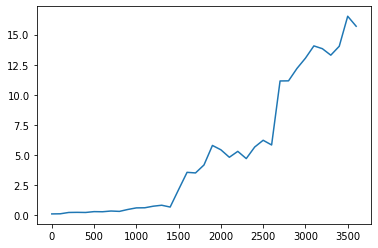

In [ ]:
render=False
save_model = False
number_of_steps = 100000
epsilon = 1.0
####Code to compute total reward####

total_reward = torch.zeros(num_envs).to(DEFAULT_DEVICE)
step_list=[]
fc_list=[] #food collected
best_fc = 0
####Code to compute total reward####


agent.train()

state=env.reset()
#Learning
for i in range(0,number_of_steps):
    ##############Learning#############################
    action = agent.action(state) 
    next_state, reward, terminal, _ = env.step(action)
    agent.update(next_state, reward, terminal)  
    state = next_state

    #############Validation############################
    if i%100 == 0:
        agent.evaluate()                        
        t_state = test_env.reset()
        fc_sum = torch.zeros((test_num_envs,)).float().to(DEFAULT_DEVICE) #foot collected
        #hit_terminal = torch.zeros((test_num_envs,)).bool().to(DEFAULT_DEVICE)
        for _ in range(1000): #max steps
            t_action = agent.action(t_state)
            t_next_state, t_reward, t_terminal, _ = test_env.step(t_action)
            #anything with a positive reward is considered as food.
            fc_sum+=(t_reward>0).float()
            #hit_terminal |= t_terminal
            t_state = t_next_state
            if t_terminal.all():
                break

        t_sum = fc_sum.cpu().numpy()
        t_mean = np.mean(t_sum)
        print('Step:', i)
        print("Episode Completed:", t_terminal.sum().cpu().numpy(), "/", test_num_envs)
        print("Mean, Median, Max, Min, std:", 
              t_mean, 
              np.median(t_sum),
              np.max(t_sum),
              np.min(t_sum),
              np.std(t_sum))
        fc_list.append(t_mean)
        step_list.append(i)
        plt.plot(step_list, fc_list)
        plt.show()
        agent.train()
        clear_output(wait=True)
        if t_mean>best_fc:
            best_fc = t_mean
            #torch.save(agent.model,"models/best_model.h5")
        
    



## Loading a saved file

In [ ]:
agent.load("models/perfect_model.h5")
print(agent.model)

## Visualize and Record Gameplay

In [ ]:
%%time
env = SingleSnake(num_envs=1, size=10, observation_mode='one_channel', device= DEFAULT_DEVICE)
agent.evaluate()
PATH = os.getcwd()
state = env.reset()
for episode in range(10):
    fc_sum = 0
    recorder = VideoRecorder(env, path=PATH + f'/videos/PG_{episode}.mp4')
    env.render()
    recorder.capture_frame()
    time.sleep(0.2)
    counter = 0
    while(1):
        counter+=1
        action = agent.action(state)
        next_state, reward, terminal, _ = env.step(action)
        fc_sum+= (reward>0).cpu().numpy()
        env.render()
        recorder.capture_frame()
        #time.sleep(0.2)
        state = next_state
        if terminal.all() or counter==1000:
            recorder.close()
            break
    print("Completed:", terminal.any().cpu().numpy())
    print('Episode:', episode, 'Food Collected:', fc_sum)

env.close()

## Computing Average Return

In [ ]:
test_env = SingleSnake(num_envs=num_envs, size=10, observation_mode='one_channel', device= DEFAULT_DEVICE, auto_reset=False)
agent.evaluate()

                       
t_state = test_env.reset()
fc_sum = torch.zeros((num_envs,)).float().to(DEFAULT_DEVICE) #foot collected

for steps in range(1000): #max steps
    t_action = agent.action(t_state)
    t_next_state, t_reward, t_terminal, _ = test_env.step(t_action)
    #anything with a positive reward is considered as food.
    fc_sum+=(t_reward>0).float()
    t_state = t_next_state
    if t_terminal.all():
        break

t_sum = fc_sum.cpu().numpy()

t_mean = np.mean(t_sum)
print("Completed:", t_terminal.sum().cpu().numpy(), "/", num_envs)
print("Mean, Median, Max, Min, std:", 
      t_mean, 
      np.median(t_sum),
      np.max(t_sum),
      np.min(t_sum),
      np.std(t_sum))